# PyTorch Hypercolumn CNN  for Zurich Dataset

In [1]:
# import libraries
import pandas as pd
import os, sys
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.gaussian_process.kernels import RBF
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import numpy as np
import gc
from helpers_pytorch import *

# custom libraries
base_dir = '/raid/home/cwendl'  # for guanabana
sys.path.append(base_dir + '/SIE-Master/Code')  # Path to density Tree package
from helpers.data_loader import ZurichLoader
from helpers.helpers import *
from helpers.parameter_search import *
from hypercolumn import HyperColumn

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
# load datasets
base_dir = '/raid/home/cwendl'  # for guanabana
root_dir = base_dir + '/SIE-Master/Zurich'
patch_size = 64
class_to_remove = 2
paramsearch = True

# load data
dataset_train = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=patch_size, transform='augment',
                             class_to_remove=class_to_remove)
dataset_val = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=patch_size,
                           class_to_remove=class_to_remove)
dataset_test = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=patch_size,
                            class_to_remove=class_to_remove)

dataloader_train = DataLoader(dataset_train, batch_size=100, shuffle=True, num_workers=20)
dataloader_val = DataLoader(dataset_val, batch_size=100, shuffle=False, num_workers=20)
dataloader_test = DataLoader(dataset_test, batch_size=100, shuffle=False, num_workers=20)

# load patches with overlap (for prediction)
dataset_train_overlap = ZurichLoader(root_dir, 'train', patch_size=patch_size, stride=int(patch_size/2), 
                                     inherit_loader=dataset_train)
dataset_val_overlap = ZurichLoader(root_dir, 'val', patch_size=patch_size, stride=int(patch_size/2), 
                                   inherit_loader=dataset_val)
dataset_test_overlap = ZurichLoader(root_dir, 'test', patch_size=patch_size, stride=int(patch_size/2), 
                                    inherit_loader=dataset_test)

dataloader_train_overlap = DataLoader(dataset_train_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_val_overlap = DataLoader(dataset_val_overlap, batch_size=100, shuffle=False, num_workers=40)
dataloader_test_overlap = DataLoader(dataset_test_overlap, batch_size=100, shuffle=False, num_workers=40)

In [3]:
# train or load CNN model
train_bool = False

model = HyperColumn(in_dim=4, out_dim=9, n_filters=32, patch_size=patch_size).cuda()
if train_bool:
    train(model, dataloader_train, dataloader_val, epochs=200, verbosity=1, plot=True, class_to_remove=class_to_remove)
    
    # save model
    state = {'model': model.state_dict(), 
             'n_epochs': 50,
             'loss_tr':0.
            }
    torch.save(state, 'models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
     
else:  # load saved model
    state = torch.load('models/model_wo_cl_' + str(class_to_remove) + '.pytorch')
    model.load_state_dict(state['model'])

In [4]:
# predict

# train
preds_tr = predict_softmax(model, dataloader_train_overlap)
preds_tr = remove_overlap(dataset_train.imgs, preds_tr, np.arange(10), patch_size=patch_size, stride=int(patch_size/2))
preds_tr = np.concatenate(preds_tr)

# val
preds_val = predict_softmax(model, dataloader_val_overlap)
preds_val = remove_overlap(dataset_val.imgs, preds_val, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_val = np.concatenate(preds_val)

# test
preds_te = predict_softmax(model, dataloader_test_overlap)
preds_te = remove_overlap(dataset_test.imgs, preds_te, np.arange(5), patch_size=patch_size, stride=int(patch_size/2))
preds_te = np.concatenate(preds_te)

145it [00:11, 12.94it/s]
47it [00:03, 14.47it/s]
48it [00:03, 14.12it/s]


In [5]:
# free GPU memory
while gc.collect():
    torch.cuda.empty_cache()

In [6]:
# get labels
pred_labels_tr = get_y_pred_labels(preds_tr, class_to_remove=class_to_remove, background=False)
pred_labels_val = get_y_pred_labels(preds_val, class_to_remove=class_to_remove, background=False)
pred_labels_te = get_y_pred_labels(preds_te, class_to_remove=class_to_remove, background=False)

In [7]:
# get indices of correctly / incorrectly predicted pixels
# train
pred_t_tr = (dataset_train.gt_patches != class_to_remove) & (dataset_train.gt_patches != 0)
pred_f_tr = dataset_train.gt_patches == class_to_remove

# val
pred_t_val = (dataset_val.gt_patches != class_to_remove) & (dataset_val.gt_patches != 0)
pred_f_val = dataset_val.gt_patches == class_to_remove

# test
pred_t_te = (dataset_test.gt_patches != class_to_remove) & (dataset_test.gt_patches != 0)
pred_f_te = dataset_test.gt_patches == class_to_remove

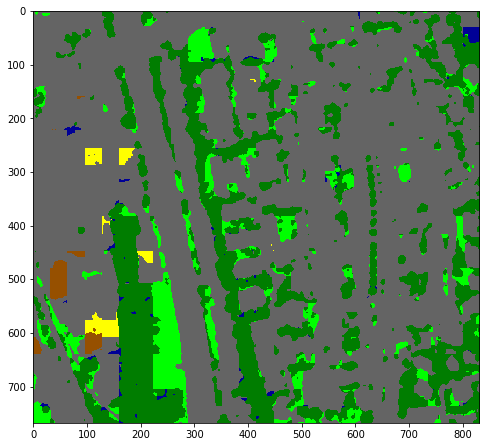

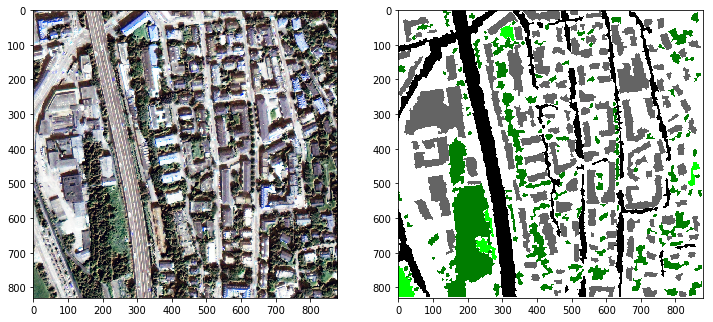

In [8]:
img_idx = 1

img = convert_patches_to_image(dataset_train.imgs, pred_labels_tr[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img[..., 0], dataset_train.colors)*255)
plt.show()

# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_train.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_train.gt[img_idx], dataset_train.colors)*255)
plt.show()

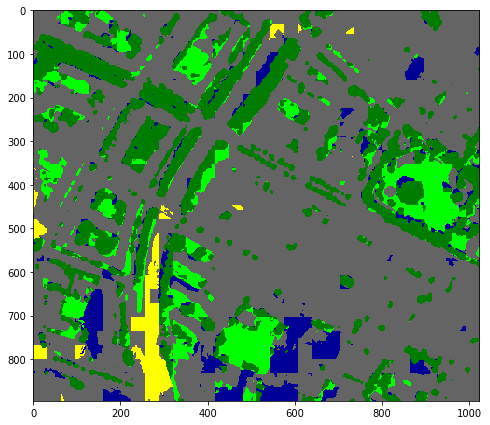

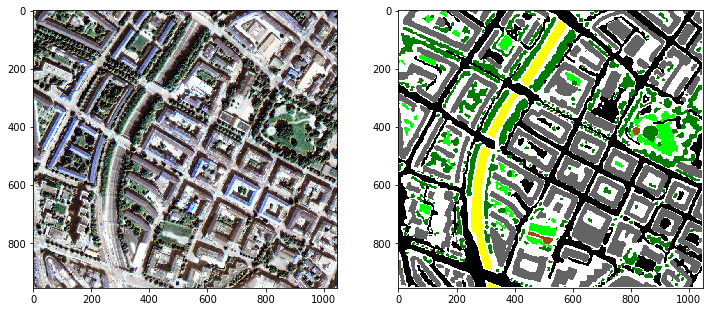

In [9]:
img_idx = 2

img = convert_patches_to_image(dataset_val.imgs, pred_labels_val[..., np.newaxis], img_idx, patch_size, patch_size, 0)

# pred
plt.figure(figsize=(8, 8))
plt.imshow(gt_label_to_color(img[..., 0], dataset_val.colors)*255)
plt.show()

# im
fig, axes = plt.subplots(1, 2, figsize=(12, 7))
axes[0].imshow(dataset_val.imgs[img_idx][..., :3])
axes[1].imshow(gt_label_to_color(dataset_val.gt[img_idx], dataset_val.colors)*255)
plt.show()

In [10]:
# class names and colors
names = dataset_train.names
colors = dataset_train.colors
n_classes = 9
classes_to_keep = np.asarray([x for x in range(1, n_classes) if x != class_to_remove])
names_keep = np.asarray(names)[classes_to_keep]
print("classes to keep: " + str(names_keep))

classes to keep: ['Buildings' 'Trees' 'Grass' 'Bare Soil' 'Water' 'Railways'
 'Swimming Pools']


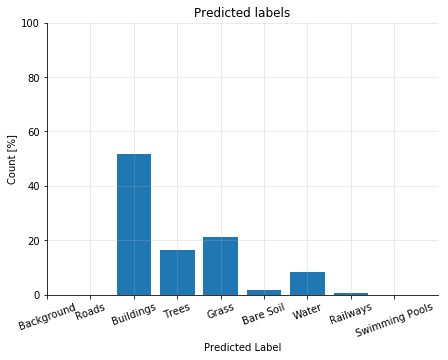

In [11]:
# distribution of predicted labels in test set
pred_labels, pred_counts = np.unique(pred_labels_te, return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Predicted labels")
plt.xticks(np.arange(len(names)), names, rotation=20)
plt.show()

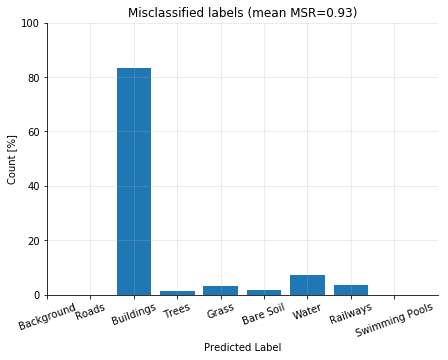

In [12]:
# distribution of predicted label that were misclassified
pred_labels, pred_counts = np.unique(pred_labels_te[pred_f_te], return_counts=True)
pred_counts = pred_counts / sum(pred_counts) * 100

# visualization
fig = plt.figure(figsize=(7, 5))
plt.bar(pred_labels, pred_counts)
plt.xticks(np.arange(0, 10))
plt.ylim([0, 100])
plt.xlabel("Predicted Label")
plt.ylabel("Count [%]")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.title("Misclassified labels (mean MSR=%.2f)" % np.mean(get_acc_net_msr(preds_te[pred_f_te])))
plt.xticks(np.arange(len(names)), names, rotation=20)
plt.savefig("Figures/Pred_count/ZH_pred-count_wo_cl" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [13]:
# TODO get weights
# p = [p for p in model.parameters()]
# for p_ in p:
    # print(p_.cpu().detach().numpy().shape)

In [14]:
ones = np.ones(len(np.unique(dataset_train.gt_patches)))
ones[0] = 0
weight = torch.from_numpy(ones).float().cuda()
f_loss = nn.CrossEntropyLoss(weight=weight)
p = test(model, f_loss, dataloader_train, "Train", verbosity=1)
p = test(model, f_loss, dataloader_val, "Val", verbosity=1)
p = test(model, f_loss, dataloader_test, "Test", verbosity=1)

Train set: Average loss: 0.0150, Accuracy: 91.45%
Val set: Average loss: 0.0155, Accuracy: 86.59%
Test set: Average loss: 0.0155, Accuracy: 84.66%


In [15]:
# Accuracy measures for each class
y_preds = [pred_labels_tr, pred_labels_val, pred_labels_te]
datasets = [dataset_train, dataset_val, dataset_test]

aa_sets, oa_sets = [], []
for y_pred, y_true in zip(y_preds, datasets):
    y_pred_flattened = np.asarray(y_pred.flatten()).astype('int') 
    y_true_flattened = np.asarray(y_true.gt_patches.flatten()).astype('int') 

    # mask background and removed classes for evaluation metrics
    filter_items = (y_true_flattened != 0) & (y_true_flattened != class_to_remove)
    
    aa_set, _ = aa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    oa_set = oa(y_true_flattened[filter_items], y_pred_flattened[filter_items])
    print("OA: %.3f, AA: %.3f" % (oa_set, aa_set))  # slightly higher accuracy because of overlapping patches
    oa_sets.append(oa_set)
    aa_sets.append(aa_set)

OA: 0.930, AA: 0.896
OA: 0.880, AA: 0.760
OA: 0.864, AA: 0.725


In [16]:
# TODO save CSV
# write metrics to CSV files
df_metrics = pd.read_csv('models/metrics_ND.csv', index_col=0)
accs = np.concatenate([[oa_sets[i], aa_sets[i]] for i in range(3)])  # [oa, aa] for tr, val, te
df2 = pd.DataFrame({str(names[class_to_remove]):accs},
                   index = ['OA Train', 'AA Train', 'OA Val', 'AA Val', 'OA Test', 'AA Test']).T
df_metrics = df_metrics.append(df2)
df_metrics = df_metrics[~df_metrics.index.duplicated(keep='last')]  # avoid duplicates
df_metrics.to_csv('models/metrics_ND.csv')
print((df_metrics*100).round(2).to_latex())

\begin{tabular}{lrrrrrr}
\toprule
{} &  OA Train &  AA Train &  OA Val &  AA Val &  OA Test &  AA Test \\
\midrule
Water                                              &     69.42 &     61.42 &   67.09 &   52.39 &    69.84 &    55.40 \\
Railways                                           &     74.47 &     79.01 &   71.17 &   73.57 &    72.87 &    79.15 \\
Swimming Pools                                     &     70.80 &     66.04 &   67.94 &   56.11 &    69.17 &    64.45 \\
[['Background' 'Roads' 'Buildings' 'Trees' 'Gra... &     83.47 &     87.14 &   80.04 &   83.27 &    77.49 &    80.74 \\
Buildings                                          &     84.29 &     81.93 &   78.59 &   67.88 &    76.74 &    64.83 \\
Grass                                              &     82.52 &     85.38 &   77.71 &   71.31 &    79.56 &    69.58 \\
Trees                                              &     83.18 &     80.25 &   76.07 &   66.53 &    82.17 &    64.85 \\
Bare Soil                                    

# Network

In [17]:
# precision-recall curves
y_true = pred_f_te.flatten()

# msr
y_scores = (-get_acc_net_msr(preds_te)).flatten()
precision_msr, recall_msr, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_msr = metrics.average_precision_score(y_true, y_scores)
auroc_msr = metrics.roc_auc_score(y_true, y_scores)
fpr_msr, tpr_msr, _ = metrics.roc_curve(y_true, y_scores)

# margin
y_scores = (-get_acc_net_max_margin(preds_te)).flatten()
precision_margin, recall_margin, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_margin = metrics.average_precision_score(y_true, y_scores)
auroc_margin = metrics.roc_auc_score(y_true, y_scores)
fpr_margin, tpr_margin, _ = metrics.roc_curve(y_true, y_scores)

# entropy
y_scores = (-get_acc_net_entropy(preds_te)).flatten()
precision_entropy, recall_entropy, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_entropy = metrics.average_precision_score(y_true, y_scores)
auroc_entropy = metrics.roc_auc_score(y_true, y_scores)
fpr_entropy, tpr_entropy, _ = metrics.roc_curve(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_msr, pr_auc_msr))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_margin, pr_auc_margin))
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_entropy, pr_auc_entropy))

AUROC: 0.50, PR AUC: 0.15
AUROC: 0.49, PR AUC: 0.14
AUROC: 0.51, PR AUC: 0.15


In [18]:
# visualization
# MSR
probas_patches_msr = np.reshape((get_acc_net_msr(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_msr -= np.min(probas_patches_msr)
probas_patches_msr /= np.max(probas_patches_msr)

# margin
probas_patches_margin = np.reshape((get_acc_net_max_margin(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_margin -= np.min(probas_patches_margin)
probas_patches_margin /= np.max(probas_patches_margin)

# entropy
probas_patches_entropy = np.reshape((get_acc_net_entropy(preds_te)).flatten(), np.shape(dataset_test.gt_patches))
probas_patches_entropy -= np.min(probas_patches_entropy)
probas_patches_entropy /= np.max(probas_patches_entropy)

base_folder = "Figures/Im_cert/cl_" + str(class_to_remove)

# show images
for img_idx in range(len(dataset_test.imgs)):
    acc_im_msr = convert_patches_to_image(dataset_test.imgs, probas_patches_msr[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_msr = imgs_stretch_eq([acc_im_msr])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_msr[..., 0], cmap='RdYlGn')
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_msr_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_margin = convert_patches_to_image(dataset_test.imgs, probas_patches_margin[..., np.newaxis],
                                             img_idx, 64, 64, 0)
    acc_im_margin = imgs_stretch_eq([acc_im_margin])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_margin[..., 0], cmap='RdYlGn')
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_margin_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()
    
    acc_im_entropy = convert_patches_to_image(dataset_test.imgs, probas_patches_entropy[..., np.newaxis],
                                              img_idx, 64, 64, 0)
    acc_im_entropy = imgs_stretch_eq([acc_im_entropy])[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(acc_im_entropy[..., 0], cmap='RdYlGn')
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_net_entropy_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Dropout

In [19]:
# get softmax scores with dropout
n_iters = 10
probas_dropout = predict_softmax_w_dropout(model, dataloader_test, n_iters)

100%|██████████| 10/10 [00:28<00:00,  2.83s/it]


AUROC: 0.64, PR AUC: 0.19


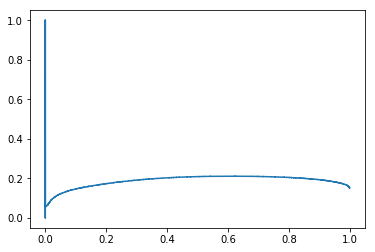

In [20]:
# metrics
y_scores = -get_acc_net_entropy(np.mean(probas_dropout, 0)).flatten()

# PR
precision_dropout, recall_dropout, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_dropout = metrics.auc(recall_dropout, precision_dropout)

# ROC
fpr_dropout, tpr_dropout, _ = metrics.roc_curve(y_true, y_scores)
auroc_dropout = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_dropout, precision_dropout)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_dropout, pr_auc_dropout))

In [21]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [22]:
# export images
probas_patches_dropout = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_dropout -= np.min(probas_patches_dropout)
probas_patches_dropout /= np.max(probas_patches_dropout)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_dropout = convert_patches_to_image(dataset_test.imgs, probas_patches_dropout[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_dropout = imgs_stretch_eq([acc_im_dropout])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_dropout[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_dropout_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Retrieve Activations

In [23]:
act_val = get_activations(model, dataloader_val_overlap, 64)

47it [00:26,  1.80it/s]


In [24]:
del dataset_val_overlap, dataloader_val_overlap

## PCA

In [25]:
# python libraries
from sklearn.manifold import TSNE
from sklearn import decomposition, svm, preprocessing
from sklearn.mixture import GaussianMixture
from sklearn.gaussian_process.kernels import RBF
from sklearn import metrics

# custom libraries
from helpers.parameter_search import *
from density_forest.density_forest import *
from density_forest.plots import *
from density_forest.helpers import *

In [26]:
print(np.shape(draw_subsamples(act_val, .1)))
print(np.shape(np.concatenate(np.concatenate(draw_subsamples(act_val, .1)))))

(117, 64, 64, 484)
(479232, 484)


In [27]:
ind_bal = get_balanced_subset_indices(dataset_test.gt_patches.flatten(), np.arange(1, 9)).flatten()

In [28]:
# create density tree for activation weights of training data
# PCA
pca = decomposition.PCA(n_components=.95)

# TODO fit on training set without background pixels
pca.fit(draw_subsamples(np.concatenate(np.concatenate(draw_subsamples(act_val, .1)))))  
n_components = np.alen(pca.explained_variance_ratio_)
print("Variance explained by first %i components: %.2f" % (
    n_components, sum(pca.explained_variance_ratio_)))

Variance explained by first 20 components: 0.95


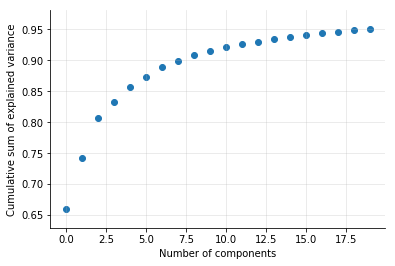

In [29]:
# Plot cumulative explained variance
fig = plt.figure()
plt.scatter(np.arange(n_components), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative sum of explained variance")
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.savefig("Figures/PCA/pca_components_wo_cl_" + str(class_to_remove) + ".pdf",
            bbox_inches='tight', pad_inches=0)

In [30]:
act_val = pca.transform(np.concatenate(np.concatenate(act_val)))[..., :10]

In [31]:
# get other activations

# test
act_test = get_activations(model, dataloader_test_overlap, 64)
print(np.shape(act_test))

# PCA 
act_test = pca.transform(np.concatenate(np.concatenate(act_test)))[..., :10]
print(np.shape(act_test))
del dataset_test_overlap, dataloader_test_overlap

48it [00:27,  1.77it/s]


(1185, 64, 64, 484)
(4853760, 10)


In [32]:
# t-SNE visualization
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=500)
tsne_all = tsne.fit_transform(act_test[ind_bal])
tsne_y = dataset_test.gt_patches.flatten()[ind_bal]

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 800 samples in 0.001s...
[t-SNE] Computed neighbors for 800 samples in 0.042s...
[t-SNE] Computed conditional probabilities for sample 800 / 800
[t-SNE] Mean sigma: 0.281520
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.740536
[t-SNE] Error after 500 iterations: 0.427388


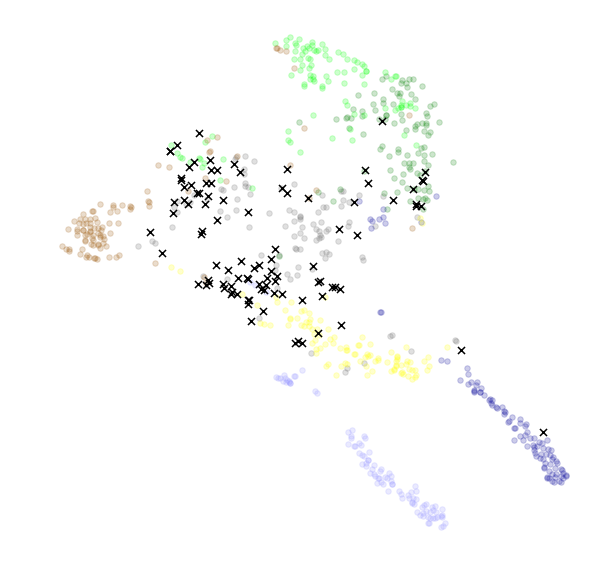

In [33]:
# plot
_, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_axis_off()
plot_pts_2d(tsne_all, tsne_y, ax, classes_to_keep, colors, class_to_remove=class_to_remove)
plt.savefig("Figures/tSNE/t-SNE_" + str(names[class_to_remove]).lower().replace(" ", "") + "_after_PCA.pdf",
            bbox_inches='tight', pad_inches=0)

In [34]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

In [35]:
# get other activations

# train
act_train = get_activations(model, dataloader_train_overlap, 64, pca)
print(act_train.shape)

145it [02:24,  1.00it/s]


(14831616, 10)


In [36]:
del dataset_train_overlap, dataloader_train_overlap

In [37]:
# clear CUDA storage
while gc.collect():
    torch.cuda.empty_cache()

# Confidence Estimation using Network Embeddings

# GMM

In [38]:
# Parameter search

best_degrees = [6, 7, 6, 9, 5, 3, 4, 9]  # TODO update for cl 1, 2, 3, 4, 5, 6, 7, 8

if paramsearch:
    tuned_parameters = [{'n_components': np.arange(1, 10), 'max_iter': [10000]}]
    # do parameter search
    ps_gmm = ParameterSearch(GaussianMixture, tuned_parameters, act_train[pred_t_tr.flatten()], act_val,
                             pred_f_tr.flatten(), scorer_roc_probas_gmm, 
                             n_iter=3, verbosity=10, n_jobs=-1, subsample_train=.01, subsample_test=.001)
    ps_gmm.fit()
    best_params = ps_gmm.best_params
else:
    best_params = {'n_components': best_degrees[class_to_remove-1], 'max_iter': 10000}
print(best_params)

Trying parameters: {'max_iter': 10000, 'n_components': 1}
Trying parameters: {'max_iter': 10000, 'n_components': 2}
Trying parameters: {'max_iter': 10000, 'n_components': 3}
Trying parameters: {'max_iter': 10000, 'n_components': 4}


[Parallel(n_jobs=40)]: Done   2 out of   9 | elapsed:   22.3s remaining:  1.3min


Trying parameters: {'max_iter': 10000, 'n_components': 5}
Trying parameters: {'max_iter': 10000, 'n_components': 6}


[Parallel(n_jobs=40)]: Done   3 out of   9 | elapsed:   26.9s remaining:   53.8s


Trying parameters: {'max_iter': 10000, 'n_components': 7}
Trying parameters: {'max_iter': 10000, 'n_components': 8}


[Parallel(n_jobs=40)]: Done   4 out of   9 | elapsed:   38.3s remaining:   47.9s


Trying parameters: {'max_iter': 10000, 'n_components': 9}


[Parallel(n_jobs=40)]: Done   5 out of   9 | elapsed:   41.1s remaining:   32.9s
[Parallel(n_jobs=40)]: Done   6 out of   9 | elapsed:   47.4s remaining:   23.7s
[Parallel(n_jobs=40)]: Done   7 out of   9 | elapsed:   52.1s remaining:   14.9s
[Parallel(n_jobs=40)]: Done   9 out of   9 | elapsed:   59.9s remaining:    0.0s
[Parallel(n_jobs=40)]: Done   9 out of   9 | elapsed:   59.9s finished


{'max_iter': 10000, 'n_components': 2}


In [39]:
# Fit GMM
gmm = GaussianMixture(**best_params)
gmm.fit(draw_subsamples(act_train[pred_t_tr.flatten()], .01))

# Predict
probas_gmm = gmm.predict_proba(act_test)
probas_gmm = get_acc_net_entropy(probas_gmm)

AUROC: 0.72, PR AUC: 0.26


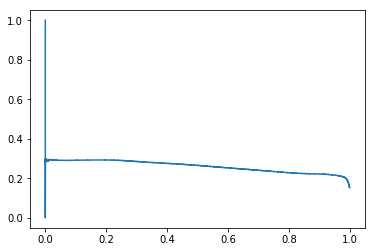

In [40]:
# metrics
y_true = pred_f_te.flatten()
y_scores = -probas_gmm

# PR
precision_gmm, recall_gmm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_gmm = metrics.auc(recall_gmm, precision_gmm)

# ROC
fpr_gmm, tpr_gmm, _ = metrics.roc_curve(y_true, y_scores)
auroc_gmm = metrics.roc_auc_score(y_true, y_scores)
plt.step(recall_gmm, precision_gmm)
print("AUROC: %.2f, PR AUC: %.2f" % (auroc_gmm, pr_auc_gmm))

In [41]:
# visualization
probas_patches_gmm = np.reshape(y_scores, np.shape(dataset_test.gt_patches))
probas_patches_gmm -= np.min(probas_patches_gmm)
probas_patches_gmm /= np.max(probas_patches_gmm)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_gmm = convert_patches_to_image(dataset_test.imgs, probas_patches_gmm[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_gmm = imgs_stretch_eq([acc_im_gmm])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_gmm[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_gmm_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# SVM

In [47]:
act_train_svm = preprocessing.scale(act_train)
act_val_svm = preprocessing.scale(act_val)
act_test_svm = preprocessing.scale(act_test)

In [ ]:
# TODO update best parameters for classes 1, 2, 3, 4, 5, 6, 7, 8
best_params = [{'kernel': 'poly', 'degree': 1, 'nu': 1e-2, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 1, 'nu': 1e-3, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 1, 'nu': 1e-1, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 3, 'nu': 1e-1, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 3, 'nu': 1e-4, 'max_iter': 10000},
               {'kernel': 'rbf',  'degree': 1, 'nu': 1e-3, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 3, 'nu': 1e-1, 'max_iter': 10000},
               {'kernel': 'poly', 'degree': 9, 'nu': 1e-1, 'max_iter': 10000},
               ]

if paramsearch:
    tuned_parameters = [{'kernel': ['rbf'],
                        'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1]
                         },
                        {'kernel': ['poly'],
                         'degree': np.arange(1, 8),
                         'nu': [1e-4, 1e-3, 1e-2, 1e-1, 5e-1],
                         'max_iter': [10000]}]

    # do parameter search
    ps_svm = ParameterSearch(svm.OneClassSVM, tuned_parameters, act_train_svm[pred_t_tr.flatten()], act_val_svm,
                             pred_f_tr.flatten(), scorer_roc_probas_svm, n_iter=5,
                             verbosity=11, n_jobs=-1, subsample_train=.0001, subsample_test=.001)
    ps_svm.fit()
    best_params = ps_svm.best_params
else:
    best_params = best_params[class_to_remove-1]
    
print(best_params)

In [ ]:
# Fit SVM
max_dim = 5  # limit to 5 components
clf_svm = svm.OneClassSVM(**best_params)
clf_svm.fit(draw_subsamples(act_train_svm[pred_t_tr.flatten(), :max_dim], .001))

In [ ]:
# predict
probas_svm = clf_svm.decision_function(act_test_svm[..., :max_dim])
probas_svm -= np.min(probas_svm)
probas_svm /= np.max(probas_svm)

In [ ]:
# metrics

y_scores = -probas_svm[:]
# PR
precision_svm, recall_svm, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_svm = metrics.auc(recall_svm, precision_svm)

# ROC
fpr_svm, tpr_svm, _ = metrics.roc_curve(y_true, y_scores)
auroc_svm = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_svm, pr_auc_svm))

#### Visualize Kernels

In [65]:
gts_train = dataset_train.gt_patches[pred_t_tr]

In [66]:
subset_ind = get_balanced_subset_indices(gts_train, classes_to_keep, pts_per_class=50)
subsample = act_train_svm[np.concatenate(subset_ind)]

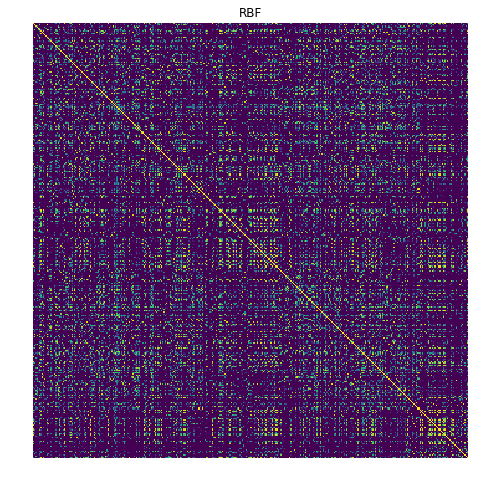

In [68]:
# RBF
K = RBF()
K_X = K.__call__(subsample)
K_X = exposure.equalize_hist(K_X)
plt.figure(figsize=(8, 8))
plt.imshow(K_X)
plt.axis('off')
plt.savefig("Figures/Kernels/Kernel_RBF_wo_cl_" + str(class_to_remove) + ".pdf", 
            bbox_inches='tight', pad_inches=0)
plt.title('RBF')

# polynomial
for deg in [1, 2, 3, 6]:
    K_X = metrics.pairwise.polynomial_kernel(subsample, degree=deg)
    # contrast stretching
    p2, p98 = np.percentile(K_X, (2, 98))
    K_X = exposure.rescale_intensity(K_X, in_range=(p2, p98))

    plt.figure(figsize=(8, 8))
    plt.imshow(K_X)
    plt.axis('off')
    plt.savefig("Figures/Kernels/Kernel_poly_wo_cl_" + str(class_to_remove) + "_deg_" + str(deg) + ".pdf",
                bbox_inches='tight', pad_inches=0)
    plt.title('Poly')
    plt.close()

## Density Forest

In [ ]:
# parameter search

# TODO update best parameters for classs 2, 3, 4, 5, 6, 7, 8
best_params = [{'max_depth': 3, 'ig_improvement': 0},
               {'max_depth': 2, 'ig_improvement': .5},
               {'max_depth': 4, 'ig_improvement': .5},
               {'max_depth': 2, 'ig_improvement': .3},
               {'max_depth': 2, 'ig_improvement': .3},
               {'max_depth': 2, 'ig_improvement': 0},
               {'max_depth': 2, 'ig_improvement': .3},
               {'max_depth': 4, 'ig_improvement': 0}
               ]


default_params = {'n_trees': 10, 'n_max_dim': 0, 'n_jobs': -1, 
                  'verbose': 0, 'subsample_pct': .0002, 'min_subset': 1e-3}

if paramsearch:
    """search for best hyperparameters"""
    tuned_params = [{'max_depth': [1, 2, 3],
                     'ig_improvement': [-np.infty, 0, .4, .7]
                    }]

    # do parameter search
    ps_df = ParameterSearch(DensityForest, tuned_params, act_train[pred_t_tr.flatten()], act_val,
                            pred_f_tr.flatten(), scorer_roc_probas_df,
                            n_iter=3, verbosity=11, n_jobs=1, subsample_train=1, 
                            subsample_test=.001, default_params=default_params)

    print("Testing %i combinations %i times" % (len(ps_df.combinations), ps_df.n_iter))
    print(ps_df.combinations)
    ps_df.fit()
    print(ps_df.best_params)
    
    # Create DensityForest instance
    best_params = ps_df.best_params
    
else:
    """use previously found hyperparameters"""
    best_params = best_params[class_to_remove-1]
    
    
print(best_params)
default_params['verbose'] = 1
default_params['batch_size'] = 10000

Testing 12 combinations 3 times
[{'ig_improvement': -inf, 'max_depth': 1}
 {'ig_improvement': -inf, 'max_depth': 2}
 {'ig_improvement': -inf, 'max_depth': 3}
 {'ig_improvement': 0, 'max_depth': 1}
 {'ig_improvement': 0, 'max_depth': 2}
 {'ig_improvement': 0, 'max_depth': 3}
 {'ig_improvement': 0.4, 'max_depth': 1}
 {'ig_improvement': 0.4, 'max_depth': 2}
 {'ig_improvement': 0.4, 'max_depth': 3}
 {'ig_improvement': 0.7, 'max_depth': 1}
 {'ig_improvement': 0.7, 'max_depth': 2}
 {'ig_improvement': 0.7, 'max_depth': 3}]
Trying parameters: {'ig_improvement': -inf, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.4s remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.6min remaining:    0.0s


Trying parameters: {'ig_improvement': -inf, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  5.8min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.4min remaining:    0.0s


Trying parameters: {'ig_improvement': 0, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 10.6min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 12.2min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.4, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 14.3min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 1, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.3min remaining:    0.0s


Trying parameters: {'ig_improvement': 0.7, 'max_depth': 2, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}
Trying parameters: {'ig_improvement': 0.7, 'max_depth': 3, 'min_subset': 0.001, 'n_jobs': -1, 'n_max_dim': 0, 'n_trees': 10, 'subsample_pct': 0.0002, 'verbose': 0}


In [58]:
# Create DensityForest instance
clf_df = DensityForest(**best_params, **default_params)

In [59]:
clf_df.fit(act_train[pred_t_tr.flatten()])

Number of points on which to train each tree: 1281
Minimum number of points in each leaf: 1


[Parallel(n_jobs=40)]: Done   8 out of  10 | elapsed:   24.5s remaining:    6.1s
[Parallel(n_jobs=40)]: Done  10 out of  10 | elapsed:   24.7s finished


Number of created root nodes: 10
Mean number of clusters created per tree: 8


In [60]:
probas_df = clf_df.predict(act_test)

Total steps: 485
Number of jobs: 40 


[Parallel(n_jobs=40)]: Done 120 tasks      | elapsed:   14.2s
[Parallel(n_jobs=40)]: Done 370 tasks      | elapsed:   37.5s
[Parallel(n_jobs=40)]: Done 484 out of 484 | elapsed:   47.3s finished


In [61]:
# metrics
y_scores = -probas_df

# PR
precision_df, recall_df, _ = metrics.precision_recall_curve(y_true, y_scores)
pr_auc_df = metrics.auc(recall_df, precision_df)

# ROC
fpr_df, tpr_df, _ = metrics.roc_curve(y_true, y_scores)
auroc_df = metrics.roc_auc_score(y_true, y_scores)

print("AUROC: %.2f, PR AUC: %.2f" % (auroc_df, pr_auc_df))

AUROC: 0.49, PR AUC: 0.14


In [62]:
# visualization
probas_patches_df = np.reshape(probas_df, np.shape(dataset_test.gt_patches))
probas_patches_df -= np.min(probas_patches_df)
probas_patches_df /= np.max(probas_patches_df)

# show image of DF uncertainty vs. max margin uncertainty
for img_idx in range(len(dataset_test.imgs)):
    acc_im_df = convert_patches_to_image(dataset_test.imgs, probas_patches_df[..., np.newaxis], img_idx, 64, 64, 0)
    acc_im_df = imgs_stretch_eq([acc_im_df])[0]
    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.imshow(acc_im_df[..., 0], cmap='RdYlGn')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.savefig(base_folder + "/ZH_wo_cl_" + str(class_to_remove) + "_df_im_" + str(img_idx) + ".pdf", 
                bbox_inches='tight', pad_inches=0)
    plt.close()

# Plots

In [ ]:
# Precision-Recall Curve
# order according to increasing score
scores_pr = [pr_auc_msr, pr_auc_margin, pr_auc_entropy, pr_auc_dropout, pr_auc_gmm, pr_auc_svm, pr_auc_df]

recalls = [recall_msr, recall_margin, recall_entropy, recall_dropout, recall_gmm, recall_svm, recall_df]
precisions = [precision_msr, precision_margin, precision_entropy, precision_dropout, 
              precision_gmm, precision_svm, precision_df]

names_methods = np.array(['MSR', 'Margin', 'Entropy', 'Dropout', 'GMM', 'OC SVM', 'DF'])
scores_order = np.argsort(scores_pr)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_pr)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(recalls[i], precisions[i], where='post', c=colors_lines[i])

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_pr[i]) for i in scores_order], title="PR AUC")
plt.savefig("Figures/Metrics/PR_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.close()

In [ ]:
# ROC
# order according to increasing score
scores_auc = [auroc_msr, auroc_margin, auroc_entropy, auroc_dropout, auroc_gmm, auroc_svm, auroc_df]
fprs = [fpr_msr, fpr_margin, fpr_entropy, fpr_dropout, fpr_gmm, fpr_svm, fpr_df]
tprs = [tpr_msr, tpr_margin, tpr_entropy, tpr_dropout, tpr_gmm, tpr_svm, tpr_df]
scores_order = np.argsort(scores_auc)
colors_lines = plt.cm.rainbow(np.linspace(0, 1, len(scores_auc)))[:, :3]

# plot
fig = plt.figure(figsize=(6, 6))
for i in scores_order:
    plt.step(fprs[i], tprs[i], where='post', c=colors_lines[i])

plt.plot([0, 1], [0, 1], '--', c='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.grid(alpha=.3)
fig.axes[0].spines['right'].set_visible(False)
fig.axes[0].spines['top'].set_visible(False)
plt.legend([str.format('%s: %.2f') % (names_methods[i], scores_auc[i]) for i in scores_order], title="AUROC")
plt.savefig("Figures/Metrics/ROC_pred_wo_cl_" + str(class_to_remove) + ".pdf", bbox_inches='tight', pad_inches=0)
plt.close()